# Project task 01: Near duplicate detection with LSH

In [1]:
import gzip
import tarfile

import numpy as np
import pandas as pd
import time

from sklearn import preprocessing
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

To goal of this task is to find near duplicate songs in the Million Song dataset. You can imagine a scenario were the same song appears on multiple different releases with only small feature variation (e.g. duration or loudness).

## 1. Load data and extract the data

We'll be working with the Million Songs Dataset, a freely-available collection of audio features and metadata for a million contemporary popular music tracks.

Specifically, we will work with a smaller subset of 10 000 songs ([download link](http://static.echonest.com/millionsongsubset_full.tar.gz)).

In [3]:
tar = tarfile.open('millionsongsubset_full.tar.gz', 'r')
members = tar.getmembers()

In [4]:
tar.extract(members[5])
summary = pd.HDFStore(members[5].name)
songs = summary['/analysis/songs']


In [5]:
print(songs.shape)

(10000, 31)


Show a snippet of how the data looks like:

In [6]:
songs.head()

,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_id
0,22050,a600d65cf157a306be60f26ecbf218f4,0.0,280.21506,0.238,0.0,0,0,0,0,...,5,0.555,-3.306,1,0.500,275.528,173.205,5,0.120,TRACCVZ128F4291A8A
1,22050,c64d75b0588e5ab552ee94548b50a4fa,0.0,191.68608,0.000,0.0,0,0,0,0,...,0,0.501,-10.764,1,0.710,184.128,150.955,4,0.600,TRACCMH128F428E4CD
2,22050,0cadd310865701bb93ced1cd78e8910a,0.0,222.92853,0.000,0.0,0,0,0,0,...,1,0.329,-9.035,1,0.407,216.300,93.056,4,1.000,TRACCSW128F148C7C3
3,22050,14be4fc1170152c445b3be7b8d18dfec,0.0,278.38649,0.496,0.0,0,0,0,0,...,7,0.313,-23.095,1,0.387,278.386,127.113,1,0.446,TRACCXJ128F428F0CF
4,22050,1def5d8298e8cb29a188a5a7c0e9429a,0.0,89.15546,4.847,0.0,0,0,0,0,...,2,0.000,-20.359,1,0.000,79.203,90.660,3,0.524,TRACCVS12903D014F8


We should have $31$ columns and $10~000$ rows.

In [7]:
print(len(songs))

10000


Since not all features are important we are going to consider a subset of features (columns) that are relevant for duplicate detection.

We will also convert the pandas dataframe into a numpy array so it is easier to work with.

In [8]:
subset = songs[['duration', 'end_of_fade_in', 'key', 'loudness',
                'mode', 'start_of_fade_out', 'tempo', 'time_signature',]]

data_matrix = subset.values
print(data_matrix.shape)

(10000, 8)


Additionally we will standardize the data to have zero mean and unit variance as a preprocessing step.

In [9]:
scaled_data = preprocessing.scale(data_matrix)
print(scaled_data)

[[ 0.36543311 -0.27872359 -0.0776891  ...  0.40602981  1.42938487
   1.13349196]
 [-0.41024005 -0.40614224 -1.48459065 ... -0.40865865  0.79697093
   0.34371217]
 [-0.13649997 -0.40614224 -1.20321034 ... -0.12189544 -0.84869805
   0.34371217]
 ...
 [ 0.89620505 -0.25249034  0.20369121 ...  0.84516828 -0.36544853
  -2.02562721]
 [-1.54800089 -0.3038861  -0.0776891  ... -1.54450728 -1.32342065
   0.34371217]
 [ 0.15967032 -0.40614224  1.61059276 ...  0.13759264 -0.07993851
   0.34371217]]


## 2. Implementaion

Your task is to implement near duplicate detection using LSH with cosine similarity.
More specifically you have to:
* Generate duplicate **candidates** based on LSH with $b$ bands and $r$ rows per band
* Refine the candidates by computing the exact cosine distance
* Report all pairs/duplicates with cosine distance < $d$

Implement a function that computes the cosine distance between two rows (instances) in the data.

In [92]:
def cosine_distance(X, i, j):
    """Compute cosine distance between two rows of a data matrix.
    
    Parameters
    ----------
    X : np.array, shape [N, D]
        Data matrix.
    i : int
        Index of the first row.
    j : int
        Index of the second row.
        
    Returns
    -------
    d : float
        Cosine distance between the two rows of the data matrix.
        
    
    Using cosine distance as distance measure will ensure the scaling (frequency of counts of a particular
    feature) of input data vectors is not considered. This is done because the dataset at hand should give 
    duplicates invariant of scaling. The cosine distance is given by 1-cos(θ), where theta is the angle between
    the two vectors such that -180<θ<=180.
    """
    d = 1- np.dot(X[i,:],X[j,:])/(np.linalg.norm(X[i,:])*np.linalg.norm(X[j,:]))
    
    return d

Cosine distance between the 5-th and the 28-th instance

In [93]:
print('{:.4f}'.format(cosine_distance(scaled_data, 5, 28)))

0.7273


In [94]:
def duplicate_pair_idx(arr,dups):

    hashTable = {}
    for i in range(0, len(arr)):
    
        if arr[i] not in hashTable:
            hashTable[arr[i]] = i
    
        else:
            dups.append((i,hashTable[arr[i]]))
     
    return dups

In [118]:
def LSH(X, b=8, r=32, d=0.3):
    """Find candidate duplicate pairs using LSH and refine using exact cosine distance.
    
    Parameters
    ----------
    X : np.array shape [N, D]
        Data matrix.
    b : int
        Number of bands.
    r : int
        Number of rows per band.
    d : float
        Distance treshold for reporting duplicates.
    
    Returns
    -------
    duplicates : {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}
        A set of tuples indicating the detected duplicates.
        Each tuple should have 3 elements:
            * ID of the first song
            * ID of the second song
            * The cosine distance between them
    
    n_candidates : int
        Number of detected candidate pairs.
        
    """
    np.random.seed(158)
    n_candidates = 0
    candidates = []
    duplicates = set()
    
    
    N,D=X.shape
    num_hashes = b*r

    ## Use cosine random projections to get a signature matrix
    rand_mat = np.random.randn(num_hashes,D)
    hash_matrix = np.matmul(rand_mat, X.T)
    signature_matrix = np.copysign(np.ones((num_hashes,N)),hash_matrix).astype(int)
    
    
    ##FILTER STEP
    #Find exact candidate pairs in each band(AND operation) and concatenate them(OR operation)
    for band in np.vsplit(signature_matrix,b):
        
        #Convert each sample in the band to a tuple and hash it's value.
        int_band = np.zeros(N)
        for i in range(N):
            sample = tuple(band[:,i])
            int_band[i] = hash(sample)

            
        ## Use a dict lookup table to extract duplicate pair indeces.
        candidates = duplicate_pair_idx(int_band,candidates)
        
        
    n_candidates = len(candidates)

    ##REFINE STEP
    #traverse the duplicate set() to check the exact duplicates using cosine distance
    for i,j in candidates:
        
        cos_distance = cosine_distance(X, i, j)
        
        if cos_distance<d:
            duplicates.add((i,j,cos_distance))
    
    
    return duplicates, n_candidates

In [119]:

start1 = time.time()
duplicates, n_candidates = LSH(scaled_data, b=3, r=64, d=0.0003)
end1 = time.time()
time_lsh = end1 - start1
print(time_lsh)

0.2114415168762207


In [70]:
print('We detected {} candidates.'.format(n_candidates))

We detected 2785 candidates.


Show the duplicates we have found:

In [71]:
duplicates

{(2569, 612, -2.220446049250313e-16),
 (5529, 3088, 0.0001736466813448967),
 (6427, 70, 0.0002997386232330701),
 (9651, 99, 0.00027760147246047584)}

Show the metadata for the songs that were detected as duplicates:

In [72]:
for i, j, d in duplicates:
    print('Song ID 1: {}'.format(i),
          'Song ID 2: {}'.format(j),
          'Distance: {:.6f}'.format(d),
          summary['/metadata/songs'].loc[i][['title', 'artist_name']].str.cat(sep=' - '),
          summary['/metadata/songs'].loc[j][['title', 'artist_name']].str.cat(sep=' - '), sep='\n')
    print()

Song ID 1: 5529
Song ID 2: 3088
Distance: 0.000174
Quiet Time - Regina Belle
Quiet Time - Regina Belle

Song ID 1: 9651
Song ID 2: 99
Distance: 0.000278
Would? - Alice In Chains
This Time I Know - Theodis Ealey

Song ID 1: 2569
Song ID 2: 612
Distance: -0.000000
Mary Had A Little Lamb - Stevie Ray Vaughan And Double Trouble
Mary Had A Little Lamb - Stevie Ray Vaughan And Double Trouble

Song ID 1: 6427
Song ID 2: 70
Distance: 0.000300
Pathfinders - Elvenking
The Flame - Chimaira



## 3. Compare runtime

Your task is to implement code for runtime comparison between LSH and the naive nested for loop implementation.

In [73]:
# naively compute the duplicates using a double for loop
def naive_duplicates(X, d = 0.2):
    """
    Parameters
    ----------
    X : np.array, shape [N, D]
        Data matrix.
    d : float
        Distance treshold for reporting duplicates.
    
    Returns
    -------
    duplicates : {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}
        A set of tuples indicating the detected duplicates.
        Each tuple should have 3 elements:
            * ID of the first song
            * ID of the second song
            * The cosine distance between them
    """
    N = X.shape[0]
    duplicates = set()
    for i in range(N):
        for j in range(N):
            d_ij = cosine_distance(X, i, j)
            if d_ij < d and i != j:
                duplicates.add((i, j, d_ij))
    return duplicates

In [84]:
def runtime_comparison():
    """
    Compare the runtime between LSH and the naive approach.
    
    Returns
    -------
    trace : [(n1, lsh_dur, naive_dur), (n2, lsh_dur, naive_dur), ... ]
            A list of tuples with execution times for different number of songs.
            Each tuple should have 3 elements:
                * number of songs considered
                * duration of the LSH approach
                * duration of the naive approach
    """
    trace = []
    for n in np.arange(1, 10001, 9999):
        print('Running comparison for {} songs.'.format(n))
        
        ### YOUR CODE HERE ###
        # Input Data of size n
        data = scaled_data[0:n, :]
        
        # Running LSH
        start1 = time.time()
        LSH(data)
        end1 = time.time()
        time_lsh = end1 - start1
        
        # Running naive method
        start2 = time.time()
        naive_duplicates(data)
        end2 = time.time()
        time_naive = end2 - start2
        
        #Append result to trace
        trace.append((n, time_lsh, time_naive))

    return trace

In [85]:
trace = runtime_comparison()

Running comparison for 1 songs.
Running comparison for 10000 songs.


KeyboardInterrupt: 

Plot the differecene in runtime. On the x-axis plot the number of songs processed and on the y-axis plot the runtime in seconds for both approaches. You should obtain a plot similar to the one shown below.

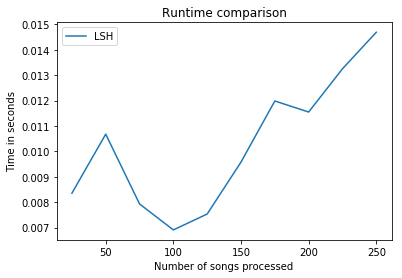

In [78]:
### YOUR PLOTTING CODE HERE ###
x = [i[0] for i in trace]
y_lsh = [i[1] for i in trace]
y_naive = [i[2] for i in trace]
plt.figure()
plt.title('Runtime comparison')
plt.xlabel('Number of songs processed')
plt.ylabel('Time in seconds')
plt.plot(x,y_lsh,label='LSH')
plt.plot(x,y_naive, label='Naive')
plt.legend()
plt.show()